In [52]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt

def average_grayscale_along_line(image, x1, y1, x2, y2):
    # Calculate the length of the line
    L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Calculate the unit direction vector
    vx = (x2 - x1) / L
    vy = (y2 - y1) / L
    
    # Initialize a list to store average grayscale values
    grayscale_values = []
    
    # Iterate over each point along the line
    for i in range(int(L)):
        x = int(x1 + i * vx)
        y = int(y1 + i * vy)
        
        # Iterate over 5 points to the left and 5 points to the right of the current point
        for j in range(-9, 10):
            x_neighbor = x + j
            if x_neighbor >= 0 and x_neighbor < image.shape[1]\
                and y >= 0 and y < image.shape[0]:
                grayscale_value = image[y, x_neighbor]
                grayscale_values.append(grayscale_value)
        
    average_grayscale = np.mean(grayscale_values)
    
    return average_grayscale

def draw_lines(img, lines, gray_thres):
    drawn_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for line in lines:
        x1, y1, x2, y2 = map(int, line[0])
        average_grayscale = average_grayscale_along_line(gray, x1, y1, x2, y2)
        if average_grayscale < gray_thres:
            cv2.line(drawn_img, (x1, y1), (x2, y2), (255, 0, 0), 1, cv2.LINE_AA)
        else:
            cv2.line(drawn_img, (x1, y1), (x2, y2), (0, 255, 0), 1, cv2.LINE_AA)
    plt.imshow(cv2.cvtColor(drawn_img, cv2.COLOR_BGR2RGB))
    # plt.show()

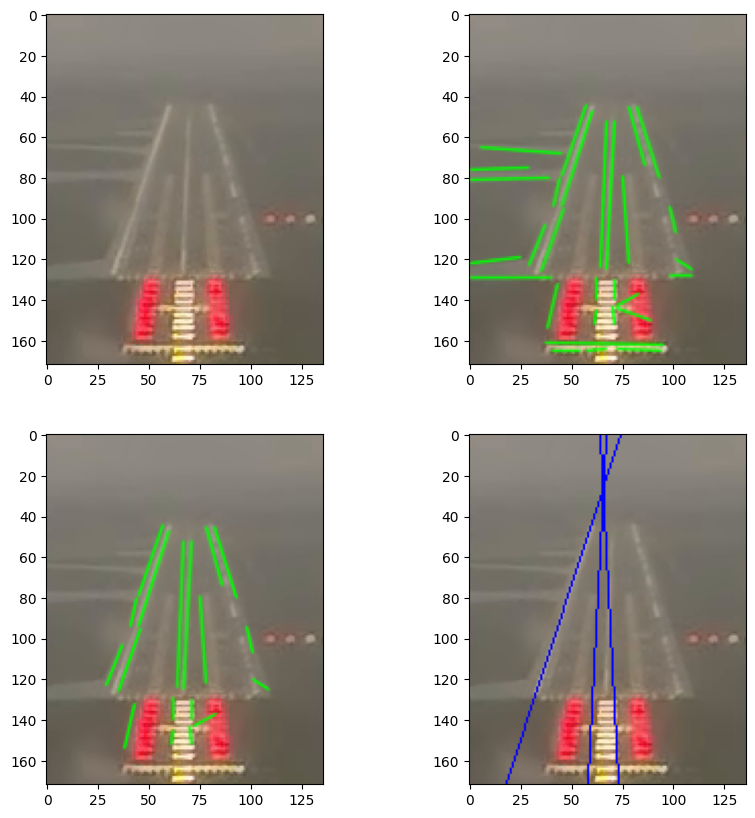

In [53]:
dir_path = "images_cropped/images"
files = os.listdir(dir_path)
img = cv2.imread(os.path.join(dir_path, files[1]))
                 
# img = cv2.imread("images/-PJP3pgLgjI_033.png")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
height, width, _ = img.shape

lsd = cv2.createLineSegmentDetector(scale=0.6, sigma_scale=0.6, quant=2.0, ang_th=22.5, log_eps=0.0, density_th=0.7, n_bins=1024)
lines, _, prec, nfa = lsd.detect(gray)

length_thres = 2
gray_thres = 0

plt.figure(figsize=[10,10])
plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# show original lines
plt.subplot(2,2,2)
draw_lines(img, lines, gray_thres)

lineList = []
for line in lines:
    # check average gray scale
    x1, y1, x2, y2 = map(int, line[0])
    average_grayscale = average_grayscale_along_line(gray, x1, y1, x2, y2)
    if average_grayscale < gray_thres:
        continue
    if np.sqrt((x1 - x2)**2 + (y1 - y2)**2) < length_thres:
        continue
    if (x1 != x2) and ( abs((y2 - y1)/(x2 - x1)) < np.tan(np.pi/8) ):
        continue

    lineList.append(line)

# show filtered lines
plt.subplot(2,2,3)
draw_lines(img, lineList, gray_thres)

mask = np.zeros([height, width], dtype=np.uint8)
for line in lineList:
    x1, y1, x2, y2 = map(int, line[0])
    cv2.line(mask, (x1, y1), (x2, y2), 255, 1)

plt.subplot(2,2,4)
lines = cv2.HoughLines(mask, 3, np.pi/180 * 3, threshold=10)
if lines is not None:
    for line in lines[:3]:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(img, (x1, y1), (x2, y2), 255, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()